In [225]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [226]:
import tensorflow as tf

In [227]:
import numpy as np
import matplotlib as mpl
import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image

import random
import datetime
import os
import pickle

In [228]:
# convert our jpg images to into a numpy array
def img_to_numpy(img_path, max_dim=None):
    image_path = img_path
    img = PIL.Image.open(image_path)
    if max_dim:
        img.thumbnail((max_dim, max_dim))
    return np.array(img)


In [229]:
# deprocess will allow us to normalize the image in the deep dream function
def deprocess(img):
    img = 255*(img + 1.0)/2.0
    return tf.cast(img, tf.uint8)

# Display an image
def show(img):
    display.display(PIL.Image.fromarray(np.array(img)))

In [230]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]

    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    return  tf.reduce_sum(losses)

In [231]:
class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
            tf.TensorSpec(shape=[], dtype=tf.int32),
            tf.TensorSpec(shape=[], dtype=tf.float32),)
    )
    
    def __call__(self, img, steps, step_size):
        print("Tracing")
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
              # This needs gradients relative to `img`
              # `GradientTape` only watches `tf.Variable`s by default
                tape.watch(img)
                loss = calc_loss(img, self.model)

            # Calculate the gradient of the loss with respect to the pixels of the input image.
            gradients = tape.gradient(loss, img)

            # Normalize the gradients.
            gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
            # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
            # You can update the image by directly adding the gradients (because they're the same shape!)
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)

        return loss, img

In [232]:
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
    shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
    shift_down, shift_right = shift[0],shift[1] 
    img_rolled = tf.roll(tf.roll(img, shift_right, axis=1), shift_down, axis=0)
    return shift_down, shift_right, img_rolled


In [233]:
class TiledGradients(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
            tf.TensorSpec(shape=[], dtype=tf.int32),)
    )
    
    def __call__(self, img, tile_size=512):
        shift_down, shift_right, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
        gradients = tf.zeros_like(img_rolled)
    
    # Skip the last tile, unless there's only one tile.
        xs = tf.range(0, img_rolled.shape[0], tile_size)[:-1]
        if not tf.cast(len(xs), bool):
            xs = tf.constant([0])
        ys = tf.range(0, img_rolled.shape[1], tile_size)[:-1]
        if not tf.cast(len(ys), bool):
            ys = tf.constant([0])

        for x in xs:
            for y in ys:
            # Calculate the gradients for this tile.
                with tf.GradientTape() as tape:
                    # This needs gradients relative to `img_rolled`.
                    # `GradientTape` only watches `tf.Variable`s by default.
                    tape.watch(img_rolled)

                    # Extract a tile out of the image.
                    img_tile = img_rolled[x:x+tile_size, y:y+tile_size]
                    loss = calc_loss(img_tile, self.model)

            # Update the image gradients for this tile.
                gradients = gradients + tape.gradient(loss, img_rolled)

        # Undo the random shift applied to the image and its gradients.
        gradients = tf.roll(tf.roll(gradients, -shift_right, axis=1), -shift_down, axis=0)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 

        return gradients 


In [234]:
def run_deep_dream_with_octaves(img, steps_per_octave=100, step_size=0.01, octaves=range(-1, 1), octave_scale=1.3):
    
    base_shape = tf.shape(img)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    initial_shape = img.shape[:-1]
    img = tf.image.resize(img, initial_shape)
    for octave in octaves:
        # Scale the image based on the octave
        new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
        img = tf.image.resize(img, tf.cast(new_size, tf.int32))

        for step in range(steps_per_octave):
            gradients = get_tiled_gradients(img)
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)

            if step % 10 == 0:
                display.clear_output(wait=True)
                show(deprocess(img))
                print ("Octave {}, Step {}".format(octave, step))
    
    result = deprocess(img)
    base_shape = tf.shape(result)[:-1]

    resize_img = tf.image.resize(result, base_shape)
    dtype_img = tf.image.convert_image_dtype(resize_img/255.0, dtype=tf.uint8)
    # show(result)
    
    np_image = np.array(dtype_img)
    final_image = PIL.Image.fromarray(np_image)

    return final_image


In [235]:
# translate values from one number range to a new range
def translate(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return round(rightMin + (valueScaled * rightSpan))


In [237]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
# names are the convolutional layers we want to maximize feautures from in our deep dream function
names = ['mixed0', 'mixed1', 'mixed2', 'mixed3', 'mixed4', 'mixed5', 'mixed6', 'mixed7', 'mixed8', 'mixed9', 'mixed10']
layers = [base_model.get_layer(name).output for name in names]


In [238]:
# setting the loaded_file to the first image file in our data directory
# that way if there is no pickle file to load we can create 
# a new one starting at the first image
path, dirs, files = next(os.walk("./data/"))
files.sort()
loaded_file = files[1]

pickle_exists = os.path.isfile('save_state.pickle')

if pickle_exists == True:
    print("loading pickle...")
    with open("save_state.pickle", 'rb') as pickle_file:
        loaded_file = pickle.load(pickle_file) 

else:
    print("creating new pickle...")
    with open("save_state.pickle", "wb") as pickle_file:
        pickle.dump(loaded_file, pickle_file)


creating new pickle...


In [239]:
target_index = files.index(loaded_file)
# removing files that we have already processed
updated_files = files[target_index:]
print("original files:\n", files)
print("updated_files\n", updated_files)

original files:
 ['.DS_Store', 'frame_0.jpg', 'frame_1.jpg', 'frame_2.jpg', 'frame_3.jpg', 'frame_4.jpg', 'frame_5.jpg', 'frame_6.jpg', 'frame_7.jpg', 'frame_8.jpg']
updated_files
 ['frame_0.jpg', 'frame_1.jpg', 'frame_2.jpg', 'frame_3.jpg', 'frame_4.jpg', 'frame_5.jpg', 'frame_6.jpg', 'frame_7.jpg', 'frame_8.jpg']


In [240]:
# create folder for our deep dream images      
dream_data_exists = os.path.exists('dream_data')

if dream_data_exists != True:
    os.makedirs('dream_data')
    print("creating dream_data folder...")

creating dream_data folder...


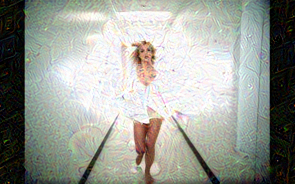

Octave -2, Step 90
layer_number 8


In [ ]:
for file in updated_files:
    # creating a pickle file to store the last iteration we were on
    # this way we can load our progress if we want to resume later
    loaded_file = file
    with open("save_state.pickle", "wb") as pickle_file:
        pickle.dump(loaded_file, pickle_file)

    # see how far our loaded_file is in the original image list and use 
    # that number to index the convolutional layer we want to want to optimize
    frame_number = files.index(file) - 1
    layer_number = translate(frame_number, 0, len(files) - 1, 0, 10)
    print("layer_number", layer_number)

    dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers[layer_number])
    deepdream = DeepDream(dream_model)
    get_tiled_gradients = TiledGradients(dream_model)

    # convert current frame to numpy, perform deep dream, save results
    numpy_img = img_to_numpy(path + file, max_dim=500)
    dream_img = run_deep_dream_with_octaves(img=numpy_img, step_size=0.01)
    dream_img.save('./dream_data/dream_frame_' + str(frame_number) + '.jpg')

print("done!")
    